<a href="https://colab.research.google.com/github/slslslrhfem/FLAGNet/blob/master/FLAGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mido

In [ ]:
pip install pretty_midi

In [ ]:
pip install tensorflow==1.15.0

In [ ]:
pip install keras==2.3.1

In [ ]:
import keras
import os
import json
import pandas
import tensorflow
import numpy as np
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras.models import Sequential
import pickle
import pretty_midi
import mido
from tqdm import tqdm
import copy
import music21
import pandas as pd

Using TensorFlow backend.


In [ ]:
tensorflow

<module 'tensorflow' from '/usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py'>

In [ ]:
def get_meta():
  file=pd.read_excel('/content/drive/MyDrive/MARG/POP909-Dataset-master/POP909/index.xlsx')
  return file

In [ ]:
with open("/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt","rb") as f:
  prettymidilist=pickle.load(f)
with open("/content/drive/My Drive/MARG/PPDDlist/midilist.txt","rb") as f1:
  midilist=pickle.load(f1)
with open('/content/drive/My Drive/MARG/PPDDlist/music21list.txt', 'rb') as f5:
  music21list=pickle.load(f5)

In [ ]:
def extract_notes(midi_part):
    parent_element = []
    ret = []
    z=[]
    for nt in midi_part.flat.notes:        
        if isinstance(nt, music21.note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
            z.append(max(nt.duration.quarterLength,0.125))
        elif isinstance(nt, music21.chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
                z.append(max(nt.duration.quarterLength,0.25))
    x=[n.offset for n in parent_element]
    return x, ret, parent_element,z
def get_ts(index_number,meta_data):
  TS=[0,0]
  TS[0]=meta_data.iloc[index_number,4]
  TS[1]=meta_data.iloc[index_number,5]
  return TS
def numbershifting(number,time):
  a=time
  while True:
    if number<a:
      a+=time
    else:
      break
  return a
def double(lst):
    return [i*2 for i in lst]
meta_data=get_meta()
"""
top = music21list[0].parts[0].flat.notes # parts[0]이 main melodty
x, y, parent_element = extract_notes(top)
print(len(y),len(x),len(parent_element))
for i in range(len(y)):
  print(x[i],y[i],parent_element[i])
"""

'\ntop = music21list[0].parts[0].flat.notes # parts[0]이 main melodty\nx, y, parent_element = extract_notes(top)\nprint(len(y),len(x),len(parent_element))\nfor i in range(len(y)):\n  print(x[i],y[i],parent_element[i])\n'

In [ ]:
#melody 만
bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
for i,songs in enumerate(music21list[100:800]):
  TS = get_ts(i,meta_data)
  if(TS!=[2,2]):#This code is used for using only 4/4 time signature
    pass
  else:
    TS=double(TS)
    pretty_song=prettymidilist[i]
    totcsvarray=[]
    for j,instrument in enumerate(pretty_song.instruments): #2
      if j==0:
        issame=1
        top = music21list[i].parts[j].flat.notes #melody만
        x, y, parent_element, duration = extract_notes(top)
        for k, element in enumerate(x):
          x[k]=float(element)
        csvarray=[]
        for j in range(len(x)): #3
          row=[x[j], y[j], y[j], duration[j], 0] #*2를 해줘야 제대로 하나의 bar가 하나의 단위가 된다. #3번째거는 원래 relational pitch라는 단위가 있었다.
          csvarray.append(row)
    one_bar_number=TS[0]
    bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
    bar_info_list=[]
    started=0
    csvarray=np.array(csvarray)
    for i in range(int(bar_number)):
      starting_bar_time=i*one_bar_number#+csvarray[0][0] -> 이걸 해주면 무조건 midi의 첫음이 첫 박의 시작이 된다. 깔끔한 processing이 가능하나 팝장르에서는 별로이고 데이터셋이 잘 정리되어 있어 별로임
      final_array=csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )]
      if (len(final_array) !=0 or started==1):
        if started==0:
          starting_number_list.append(starting_bar_time)
          started=1
        bar_info_list.append(final_array)
        
    bar_list.append(bar_info_list)# bar info list가 bar마다 csv내용들 담겨져 있는거다.
    one_bar_number_list.append(one_bar_number)

In [ ]:
print(bar_list[0][0])#1번째 곡의 1번째 bar.

[[19.0 61.0 61.0 0.25 0]
 [19.333333333333332 63.0 63.0 0.125 0]
 [19.5 66.0 66.0 0.125 0]
 [19.75 68.0 68.0 0.125 0]]


In [ ]:
Minimum_time = 4 #This value means we use 4*(Minimum_time)th note for minimum unit. Use Integer value!
#I Highly recommend you to use this value 4 or 6.(16th note and 24th note as smallest unit.)
#Using Too Small value for Minimum_time can't handle fast rhythms, and Too Large value for Minimum_time is not good for generator's training
Minimum_time*=4 #If Minimum_time value%4 is not 0, then error occurs in training generator

def nearest_time(time,minimum_size):
  #Given minimum time, there can be outliars. Shift for this. ex)32th notes in minimum unit 16th notes.
  num_to_multiply=time/minimum_size
  num_to_multiply=int(num_to_multiply)
  left_time=num_to_multiply*minimum_size
  right_time=left_time+minimum_size
  if (time-left_time>=right_time-time):
    return right_time
  return left_time

def bar_to_matrix3(bar,one_bar_number,starting_number,i,minimum_time):
  init=np.zeros((24,minimum_time))
  minimum_size=one_bar_number/minimum_time
  zero_time=starting_number+one_bar_number*i
  min_height=500
  for lists in bar:
    if min_height>lists[1]:
      min_height=lists[1]
  for i,lists in enumerate(bar):    
      point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
      length=int(round(2*lists[3]/minimum_size))
      if length==0:
        length=1
      if (length>3):
        length=length-1#Handling repeating notes.
      if (point+length>minimum_time-1):
        length=minimum_time-point
      height=lists[1]-min_height
      """
      while(height>23):
        height=height-12 
      """
      if (height<24):#two choices for handling notes that has pitch difference above 23, delete or shifting. 
      #If you want shift them then uncomment above 2 line of codes. 
        init[23-int(height)][point:point+length]+=1
        init=np.array(init)
        init=np.where(init>=2,1,init)
  return init

In [ ]:
bar_matrix_list3=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_matrix_list3):
  for j,bar in enumerate(songs): # 이러면 bar에 3차원이 들어간다.
    matrix3=bar_to_matrix3(bar,one_bar_number_list[i],starting_number_list[i],j,Minimum_time)
    bar_matrix_list3[i][j]=matrix3

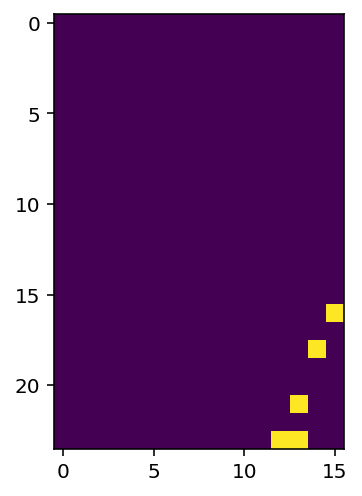

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bar_matrix_list3[0][0])

In [ ]:
bar_updown_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    if (j==len(songs)-1):
      updown_label='final'
    elif(len(bar_list[i][j])==0 or len(bar_list[i][j+1])==0):
      updown_label='meanless'
    else:
      if(bar_list[i][j][len(bar_list[i][j])-1][1]<=bar_list[i][j+1][0][1]):
        updown_label='up'
      else:
        updown_label='down'
    bar_updown_list[i][j]=updown_label

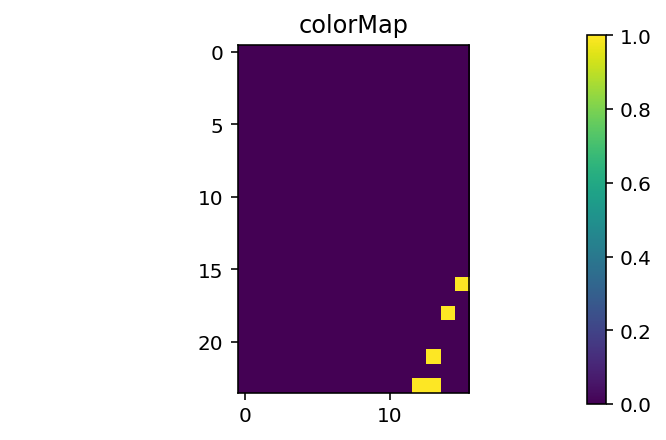

In [ ]:
H = bar_matrix_list3[0][0]

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

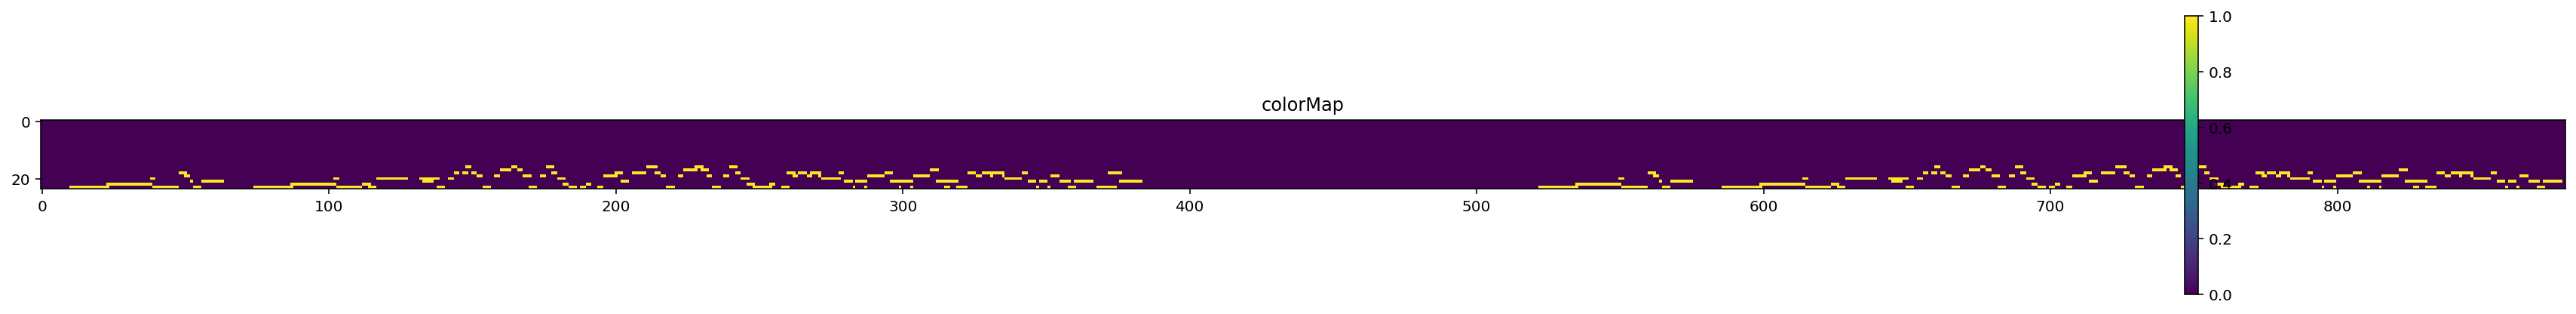

In [ ]:
tot=bar_matrix_list3[2]
H=bar_matrix_list3[2][0]
for i in range(1,len(tot)):
  a=bar_matrix_list3[2][i]
  H=np.concatenate((H,a),axis=1)
  
fig = plt.figure(figsize=(30, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
def bar_to_contour(bar,one_bar_number,starting_number,j):
  contour=[]
  pitch_change_list=[]
  duration_list=[]
  real_pitch_list=[]
  real_time_list=[]
  real_duration_list=[]
  now_pitch=1000
  first_time=starting_number+one_bar_number*j
  a=0
  for lists in bar:
    if(a!=0): 
      real_time_list.append(lists[0]-now_rhythm)
    now_rhythm=lists[0]
    a+=1
    if (first_time*1.001<lists[0]):#smoothing for case like first time=5.00001, lists[0]=5.0000..
      resting_time=lists[0]-first_time
      duration_list.append(resting_time)
      first_time=lists[0]
      pitch_change_list.append('Rest')
    if (now_pitch==1000):
      pitch_change_list.append('Starting_Point')
      real_pitch_list.append('Starting_Point')
      real_duration_list.append(lists[3])
      duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      a+=1
    else:
      pitch_change=lists[1]-now_pitch
      pitch_change_list.append(str(pitch_change))
      duration_list.append(lists[3])
      real_duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      real_pitch_list.append(str(pitch_change))
  if (first_time*1.001<starting_number+one_bar_number*(j+1)):
    pitch_change_list.append('Rest')
    duration_list.append(starting_number+one_bar_number*(j+1)-first_time)
  if(len(bar)!=0):
    real_time_list.append(starting_number+one_bar_number*(j+1)-now_rhythm)
  contour.append(pitch_change_list)
  contour.append(duration_list)
  contour.append(real_pitch_list)
  contour.append(real_time_list)
  contour.append(real_duration_list)
  return contour

Plot에서 중요한것은 Y-Axis의 0~112의 숫자가 Note의 반대 성향을 가진다는 것이다.(숫자가 커질수록 Note의 높이가 낮아진다.) 이는 PianoRoll을 이미지 처럼 사용하는 과정에서, 직관적인 학습이 가능하도록 이와 같이 구현한 것이다.

In [ ]:
bar_contour_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    contour=bar_to_contour(bar,one_bar_number_list[i],starting_number_list[i],j)
    bar_contour_list[i][j]=contour


bar_contour_list : 중간과정
bar_matrix_list2 : 아마 학습에 사용하게 될 Matrix의 List
bar_label_list : 학습에 사용하게 될 Label의 List

In [ ]:
print(bar_contour_list[0][0])


[['Rest', 'Starting_Point', 'Rest', '2.0', 'Rest', '3.0', 'Rest', '2.0', 'Rest'], [3.0, 0.25, 0.08333333333333215, 0.125, 0.04166666666666785, 0.125, 0.125, 0.125, 0.125], ['Starting_Point', '2.0', '3.0', '2.0'], [0.33333333333333215, 0.16666666666666785, 0.25, 0.25], [0.25, 0.125, 0.125, 0.125]]


In [ ]:
for contours in bar_contour_list[11]:
  print(contours)

[['Rest', 'Starting_Point', '2.0', 'Rest', '5.0', 'Rest', '0.0', 'Rest', '0.0', '-2.0', 'Rest', '2.0', 'Rest', '-2.0', 'Rest', '2.0', 'Rest', '0.0', 'Rest', '0.0', '2.0', 'Rest', '-2.0'], [0.25, 0.125, 0.125, 0.16666666666666785, 0.125, 0.20833333333333215, 0.125, 0.125, 0.25, 0.125, 0.04166666666666785, 0.25, 0.08333333333333215, 0.5, 0.16666666666666785, 0.25, 0.08333333333333215, 0.125, 0.125, 0.125, 0.25, 0.04166666666666785, Fraction(1, 3)], ['Starting_Point', '2.0', '5.0', '0.0', '0.0', '-2.0', '2.0', '-2.0', '2.0', '0.0', '0.0', '2.0', '-2.0'], [0.08333333333333215, 0.3333333333333357, 0.33333333333333215, 0.25, 0.08333333333333215, 0.3333333333333357, 0.33333333333333215, 0.6666666666666679, 0.33333333333333215, 0.25, 0.08333333333333215, 0.3333333333333357, 0.33333333333333215], [0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.25, 0.5, 0.25, 0.125, 0.125, 0.25, Fraction(1, 3)]]
[['Rest', 'Starting_Point', '-3.0', 'Rest', '3.0', 'Rest'], [0.25, 0.25, Fraction(1, 3), 0.16666666666666

In [ ]:
#최대한 많고 깔끔한 조건문을 사용하여 Skill들을 정의해볼 것. Multilabel Classification의 가능성이 있다.
"""
Skill들의 음악학적인 특성 & 계산적인 특성을 적는 곳
'resting' : 포함하는 음이 0 또는 1개인 경우 resting으로 정의. 다른 Skill들은 겹칠 수 있으나 이 skill이 Label될 경우 그냥 resting 고정이다.
즉, Skilling Labeling은 'resting'이 아닌 경우에 진행된다.(삭제)
'repeating' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 전부 같은 음일 경우 repeating으로 정의
'up_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping up 또는 같은 음, 즉 반음기준 3Note 이하로 상승하는 형태일 경우 up_steping으로 정의
'down_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping down 또는 같은 음, 즉 반음기준 3Note 이하로 하강하는 형태일 경우 down_steping으로 정의
'up_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping up, 즉 반음기준 3Note 이상으로 상승하는 형태일 경우 up_leaping으로 정의
'down_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping down, 즉 반음기준 3Note 이상으로 하강하는 형태일 경우 down_leaping으로 정의
3Note에서 겹치는게 맞다. Multilabel Classification을 고안 중이기 때문.
'steping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 2Note 이하의 상승과 하강을 반복하는 형태일 경우 steping_twisting으로 정의
'leaping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 3Note 이상의 상승과 하강을 반복하는 형태일 경우 leaping_twisting으로 정의
'fast_rhythm' : 1 bar 내에 음이 9개 이상인 경우 fast_rhythm으로 정의.
'One_rhythm' :  모든 음이 지닌 연주의 real_time, 즉 음이 울리고 다음 음이 나올때 까지의 시간이 같으면 One_rhythm으로 정의
'triplet' : real_time기반해서 triplet이 존재하면(Note 3개) triplet으로 정의
'Staccato' : real_Duration_Time 기반해서 n% 이상의 음의 Duration이 0.16667(최소단위*4임)보다 작으면(매우 짧으면) Staccato로 정의
'continuing_rhythm' : pitch_change_list에서 'Rest'의 비율이 25퍼센트 이하면 continuing_rhythm으로 정의
첫 음 제외 실 음의 75%를 기준으로 잡는다.
5개 이상의 음이 있다면 1개를 제외하고 전부 조건에 맞아야하고,
9개 이상의 음이 있다면 2개를 제외하고 전부 조건에 맞아야하고...
4개 이하는 다 맞아야 한다.
ex) CDEF -> up_steping, CDED -> None, CDEFD-> up_steping.
다만 Leaping에 대해서는 많이 후해질 것 같다. 거의 50%가까이..?  
"""

"""
예시로는..
contour[0] = ['Starting_Point', 'Rest', '4.0', '1.0', 'Rest', '2.0', 'Rest', '-7.0', 'Rest'] Note pitch의 변화를 쉼표를 포함하여 의미한다.
contour[1] = [0.83333, 0.16666999999999987, 0.5, 0.33333, 0.16666999999999987, 0.8333299999999999, 0.16666999999999987, 0.75, 0.25] Duration을 쉼표를 포함하여 의미한다.
contour[2] = ['Starting_Point', '4.0', '1.0', '2.0', '-7.0'] note pitch의 변화를 의미한다.
contour[3] = [1.0, 0.5, 0.5, 1.0, 1.0] 한 음의 실 연주시간을 의미한다.(다음 음이 나올때 까지의 시간)
contour[4] = [0.83333, 0.5, 0.33333, 0.8333299999999999, 0.75] Duration을 의미한다.
"""
def is_repeating(contour_list,exception_range):
  boolean_repeating=0
  non_repeat=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if(elements != '0.0'):
        non_repeat+=1
  if (non_repeat<=exception_range):
    boolean_repeating=1
  return boolean_repeating

def is_up_steping(contour_list,exception_range):
  balancing_param=1
  boolean_up_steping=0
  non_step_up=0
  now_step_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_up==0):
        if (float(elements)<0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
      else:
        if(float(elements)<-0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
  if(non_step_up<=exception_range+balancing_param):
    boolean_up_steping=1
  return boolean_up_steping

def is_down_steping(contour_list,exception_range):
  boolean_down_steping=0
  balancing_param=0
  non_step_down=0
  now_step_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_down==0):
        if (float(elements)>-0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
      else:
        if(float(elements)>0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
  if(non_step_down<=exception_range+balancing_param):
    boolean_down_steping=1
  return boolean_down_steping

def is_up_leaping(contour_list,exception_range):
  boolean_up_leaping=0
  non_leap_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)<3.5):
        non_leap_up+=1
  if (non_leap_up<=exception_range+1):
    boolean_up_leaping=1
  return boolean_up_leaping

def is_down_leaping(contour_list,exception_range):
  boolean_down_leaping=0
  non_leap_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)>-3.5):
        non_leap_down+=1
  if (non_leap_down<=exception_range+1):
    boolean_down_leaping=1
  return boolean_down_leaping

def is_leaping_twisting(contour_list,exception_range):
  boolean_leaping_twisting=0
  non_leap_twist=0
  balancing_param=1
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (3.5<float(elements)):
          now_dir=1
        elif (float(elements) <-3.5):
          now_dir=-1
        else:
          non_leap_twist+=1
      elif (now_dir==1):
        if (float(elements) <-3.5):
          now_dir=-1
        else:
          now_dir=0
          non_leap_twist+=1
      elif (now_dir==-1):
        if (3.5<float(elements)):
          now_dir=1
        else:
          now_dir=0
          non_leap_twist+=1
  if(non_leap_twist<=exception_range+balancing_param):
    boolean_leaping_twisting=1
  return boolean_leaping_twisting

def is_steping_twisting(contour_list,exception_range):
  boolean_steping_twisting=0
  non_step_twist=0
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        elif (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          non_step_twist+=1
      elif (now_dir==1):
        if (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          now_dir=0
          non_step_twist+=1
      elif (now_dir==-1):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        else:
          now_dir=0
          non_step_twist+=1
  if(non_step_twist<=exception_range):
    boolean_steping_twisting=1
  return boolean_steping_twisting

def is_one_rhythm(contour_list,exception_range):
  boolean_one_rhythm=0
  non_same_rhythm=0

  first_rhythm=contour_list[0]
  for rhythms in contour_list:
    if (rhythms != first_rhythm):
      non_same_rhythm=1
  boolean_one_rhythm=1-non_same_rhythm
  return boolean_one_rhythm

def is_triplet(contour_list,exception_range):
  boolean_triplet=0
  now_triplet=0
  for rhythms in contour_list:
    rhythms=float(rhythms)
    if (rhythms%0.015625>0.001):
      if(now_triplet==1):
        boolean_triplet=1
      now_triplet+=1
    else:
      now_triplet=0
      
  return boolean_triplet

def is_staccato(contour_list,exception_range):
  boolean_staccato=0
  ranges=len(contour_list)//2
  staccato_num=0
  for times in contour_list:
    if (times<0.2):
      staccato_num+=1
  if (staccato_num>=ranges):
    boolean_staccato=1
  return boolean_staccato

def is_continuing_rhythm(contour_list):
  boolean_continuing_rhythm=0
  length=len(contour_list)
  rest_num=0
  for elements in contour_list:
    if (elements=='Rest'):
      rest_num+=1
  if (rest_num<=0.5):
    boolean_continuing_rhythm=1
  return boolean_continuing_rhythm

def contour_to_label(contour):
  labels=[]
  totnum=len(contour[2]) #실 음의 갯수이다.
  exception_range=(totnum-1)//4
  exception_range2=(totnum-1)//3
  if (len(contour[2])<2.5):
    pass#원래는 resting이라는 Label을 append했으나 Control이 까다롭다
  else:
    if (is_repeating(contour[2],exception_range2)):
      labels.append('repeating')

    if (is_up_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('up_steping')

    if (is_down_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('down_steping')

    if (is_up_leaping(contour[2],exception_range2)):
      labels.append('up_leaping')
    
    if (is_down_leaping(contour[2],exception_range2)):
      labels.append('down_leaping')

    if (is_steping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('steping_twisting')

    if (is_leaping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('leaping_twisting')

    if (len(contour[2])>8.5):
      labels.append('fast_rhythm')

    if (is_one_rhythm(contour[3],exception_range)):
      labels.append('One_rhythm')

    if (is_triplet(contour[3],exception_range2)):
      labels.append('triplet')

    if (is_staccato(contour[4],exception_range2)):
      labels.append('staccato')  

    if (is_continuing_rhythm(contour[0])):
      labels.append('continuing_rhythm')  

  if (len(labels)==0):
    labels.append('no skills')#Use for Classifier and cGAN, but I don't use this label for generation


  return labels

In [ ]:
bar_label_list=copy.deepcopy(bar_contour_list)
for i,songs in enumerate(bar_contour_list):
  for j,contour in enumerate(songs):
    label=contour_to_label(contour) 
    bar_label_list[i][j]=label

In [ ]:
for j in range(len(bar_label_list[0])):
  print(bar_label_list[0][j])
  print(bar_contour_list[0][j])

['up_steping', 'steping_twisting', 'triplet', 'staccato']
[['Rest', 'Starting_Point', 'Rest', '2.0', 'Rest', '3.0', 'Rest', '2.0', 'Rest'], [3.0, 0.25, 0.08333333333333215, 0.125, 0.04166666666666785, 0.125, 0.125, 0.125, 0.125], ['Starting_Point', '2.0', '3.0', '2.0'], [0.33333333333333215, 0.16666666666666785, 0.25, 0.25], [0.25, 0.125, 0.125, 0.125]]
['up_leaping', 'down_leaping', 'leaping_twisting']
[['Starting_Point', 'Rest', '-4.0', 'Rest', '-3.0', 'Rest', '5.0', 'Rest'], [0.25, 0.25, Fraction(1, 3), 0.16666666666666785, Fraction(1, 3), 0.16666666666666785, 1.5, 1.0], ['Starting_Point', '-4.0', '-3.0', '5.0'], [0.5, 0.5, 0.5, 2.5], [0.25, Fraction(1, 3), Fraction(1, 3), 1.5]]
['triplet']
[['Starting_Point', 'Rest', '-3.0', 'Rest', '-4.0', 'Rest', '5.0', 'Rest', '-5.0', 'Rest', '2.0', 'Rest', '3.0', 'Rest', '2.0'], [Fraction(1, 3), 0.16666666666666785, 0.25, 0.25, 0.25, 0.25, 1.25, 0.25, 0.25, 0.08333333333333215, 0.125, 0.04166666666666785, 0.125, 0.125, 0.25], ['Starting_Point',

[['Rest', 'Starting_Point', 'Rest', '2.0', 'Rest', '3.0', 'Rest', '2.0', 'Rest'], [3.0, 0.25, 0.08333333333333215, 0.125, 0.04166666666666785, 0.125, 0.125, 0.125, 0.125], ['Starting_Point', '2.0', '3.0', '2.0'], [0.33333333333333215, 0.16666666666666785, 0.25, 0.25], [0.25, 0.125, 0.125, 0.125]]
['up_steping', 'steping_twisting', 'triplet', 'staccato']
[[19.0 61.0 61.0 0.25 0]
 [19.333333333333332 63.0 63.0 0.125 0]
 [19.5 66.0 66.0 0.125 0]
 [19.75 68.0 68.0 0.125 0]]


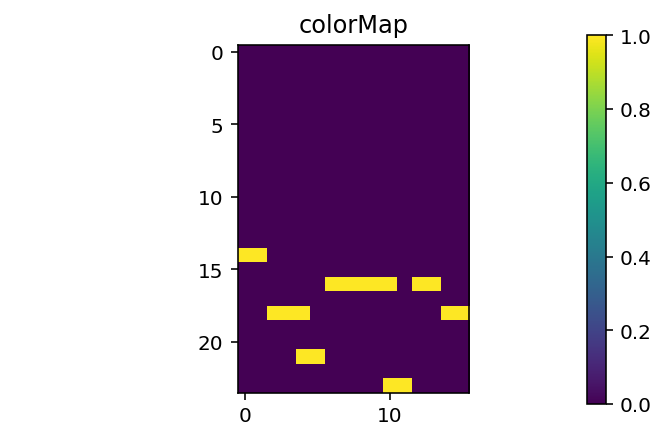

In [ ]:
#Summary
print(bar_contour_list[0][0])
print(bar_label_list[0][0])
print(bar_list[0][0])

H=bar_matrix_list3[0][3]
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

Implementation of models in FLAGNet.
Model Loading only code is in end of model implementation.
If you use pre-trained model, then running codes below the text 'Implementation of RNN'
RNN model loading is not working..

In [ ]:
all_matrix=[]
all_labels=[]
all_updown_labels=[]
for songs in bar_label_list:
  for label in songs:
    label=np.array(label)
    all_labels.append(label)
for songs in bar_matrix_list3:
  for matrix in songs:
    matrix=matrix.reshape(24,Minimum_time,1)
    all_matrix.append(matrix)
for songs in bar_updown_list:
  for label in songs:
    all_updown_labels.append(label)


In [ ]:
print(len(all_matrix),len(all_labels),len(all_updown_labels))

41716 41716 41716


In [ ]:
import keras.backend.tensorflow_backend as tfback
from tensorflow.python.client import device_lib
def _get_available_gpus():
  if tfback._LOCAL_DEVICES is None:
    devices = device_lib.list_local_devices()
    tfback._LOCAL_DEVICES = [x.name for x in devices]
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
train_matrix=np.array(all_matrix[:int(len(all_matrix)*0.85)])
train_label=np.array(all_labels[:int(len(all_matrix)*0.85)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Since label which has both 'up_steping' and 'down_steping' is impossible, setting label against with these impossible cases to improve classifier's performance.
def set_labels():
  labels=[]
  label_tuple=[]
  skills_pitch=['repeating','up_steping','down_steping','up_leaping','down_leaping','steping_twisting','leaping_twisting','dummy']
  skills_timing=['fast_rhythm','dummy']
  skills_triplet=['triplet','dummy']
  skills_one_rhythm=['One_rhythm','dummy']
  skills_staccato=['staccato','continuing_rhythm','dummy']
  for pitch in skills_pitch:
    for timing in skills_timing:
      for triplet in skills_triplet:
        for one_rhythm in skills_one_rhythm:
          for staccato in skills_staccato:
            label_tuple=[]
            if pitch is not 'dummy':
              label_tuple.append(pitch)
            if timing is not 'dummy':
              label_tuple.append(timing)
            if triplet is not 'dummy':
              label_tuple.append(triplet)
            if one_rhythm is not 'dummy':
              label_tuple.append(one_rhythm)
            if staccato is not 'dummy':
              label_tuple.append(staccato)
            if len(label_tuple)==0:
              label_tuple.append('no skills') # no skills label is used for training classifier and generator, but not used for real generation.
            label_tuple=tuple(label_tuple)
            
            labels.append(label_tuple)
  
  return labels
label=set_labels()

In [ ]:
valid_matrix=np.array(all_matrix[int(len(all_matrix)*0.85):int(len(all_matrix)*0.95)])
valid_label=np.array(all_labels[int(len(all_matrix)*0.85):int(len(all_matrix)*0.95)])
test_matrix=np.array(all_matrix[int(len(all_matrix)*0.95):])
test_label=np.array(all_labels[int(len(all_matrix)*0.95):])#Maybe can used in implementation..
mlb=MultiLabelBinarizer()
labels=set_labels()
mlb.fit(labels)
train_label2=mlb.transform(train_label)
valid_label2=mlb.transform(valid_label)
test_label2=mlb.transform(test_label)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
print(train_label2.shape)

(35458, 13)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
updownle=LabelBinarizer()
updownle.fit(['up','down','final','meanless'])
updown_label=updownle.transform(np.array(all_updown_labels))

In [ ]:
train_updown_label=updown_label[:int(len(all_matrix)*0.85)]
valid_updown_label=updown_label[int(len(all_matrix)*0.85):int(len(all_matrix)*0.95)]
test_updown_label=updown_label[int(len(all_matrix)*0.95):]

In [ ]:
print(train_matrix.shape)
print(train_label2)
print(valid_matrix.shape)

(35458, 24, 16, 1)
[[0 0 0 ... 1 0 1]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]]
(4172, 24, 16, 1)


In [ ]:
import keras.applications
from keras import regularizers
from keras.applications import VGG16
from keras.applications import resnet50
from keras import layers
from tensorflow import keras
def residual_block(filter, input, add=True):
  with tf.device('/gpu:0'):
    layer_1 = keras.layers.Conv2D(filters=filter//4, kernel_size=(1, 1), data_format="channels_first")(input)
    layer_2 = keras.layers.Conv2D(filters=filter//4, kernel_size=(3, 3), padding='same', data_format="channels_first", kernel_regularizer=keras.regularizers.l2(0.001))(layer_1)
    layer_2 = keras.layers.BatchNormalization()(layer_2)
    layer_2 = keras.layers.ReLU()(layer_2)
    layer_3 = keras.layers.Conv2D(filters=filter, kernel_size=(1, 1), data_format="channels_first")(layer_2)
    layer_3 = keras.layers.BatchNormalization()(layer_3)
    if add:
        layer_3 = keras.layers.add([input, layer_3])
    layer_3 = keras.layers.ReLU()(layer_3)
    return layer_3
def make_model(minimum_time):
  with tf.device('/gpu:0'):
    input_layer = keras.Input(shape=(24, minimum_time, 1))
    layer_1 = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', data_format="channels_first")(input_layer)
    block_1 = residual_block(64, layer_1)
    #block_2 = residual_block(64, block_1)
    #block_3 = residual_block(64, block_2)
    pooling_layer = keras.layers.MaxPool2D((2, 2),padding='same', data_format="channels_first")(block_1)
    block_4 = residual_block(128, pooling_layer, add=False)
    block_5 = residual_block(128, block_4)
    #block_6 = residual_block(128, block_5)
    pooling_layer2 = keras.layers.MaxPool2D(padding='same',pool_size=(2, 2), data_format="channels_first")(block_4)
    block_7 = residual_block(256, pooling_layer2, add=False)
    block_8 = residual_block(256, block_7)
    block_9 = residual_block(256, block_8)
    #pooling_layer4 = keras.layers.MaxPool2D(pool_size=(2, 2), data_format="channels_first")(block_7)
    #block_10 = residual_block(256, pooling_layer4)
    #block_11 = residual_block(512, block_10)
    pooling_layer3 = keras.layers.AvgPool2D(padding='same',pool_size=(8, 8), data_format="channels_first")(block_7)
    last_layer = keras.layers.Flatten()(pooling_layer3)
    last_layer = keras.layers.Dropout(0.4)(last_layer)
    last_layer = keras.layers.Dense(13, activation="sigmoid")(last_layer)
    return keras.models.Model(inputs=input_layer, outputs=last_layer)
def make_classifier(minimum_time):
  with tf.device('/gpu:0'):
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same',
                  activation='relu',
                  input_shape=(24,minimum_time,1)))
    classifier.add(keras.layers.BatchNormalization())
    classifier.add(keras.layers.LeakyReLU(alpha=0.01))
    classifier.add(keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    classifier.add(keras.layers.Conv2D(256, (2, 2), padding='same'))
    classifier.add(keras.layers.LeakyReLU(alpha=0.01))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dropout(0.25))
    classifier.add(keras.layers.Dense(4, activation='sigmoid'))
  return classifier

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_path = '/content/drive/My Drive/MARG/models/' + 'deeperppddbest.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)
callbacks = [cb_checkpoint]

model_path = '/content/drive/My Drive/MARG/models/' + 'updown.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)
updown_callbacks=[cb_checkpoint]
#tf.keras(make_model) : monitor='val_acc', keras(make_classifier) : monitor='val_accuracy'

In [ ]:
from keras import backend as K
import tensorflow as tf
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)
    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


In [ ]:
from tensorflow import keras
classifier=make_model(Minimum_time)
classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='binary_crossentropy'
  ), optimizer='adam', metrics=['accuracy',recall,precision,f1score])

hist=classifier.fit(
      train_matrix,train_label2,batch_size=256,
      epochs=50,
      validation_data=(valid_matrix,valid_label2),
      callbacks=callbacks,
      class_weight='balanced'
  )

#Training


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 35458 samples, validate on 4172 samples
Epoch 1/50
33792/35458 [===========================>..] - ETA: 0s - loss: 0.4413 - acc: 0.8868 - recall: 0.2276 - precision: 0.5756 - f1score: 0.3215
Epoch 00001: val_acc improved from -inf to 0.85760, saving model to /content/drive/My Drive/MARG/models/deeperppddbest.h5
35458/35458 [==============================] - 7s 186us/sample - loss: 0.4388 - acc: 0.8873 - recall: 0.2322 - precision: 0.5806 - f1score: 0.3269 - val_loss: 0.5065 - val_acc: 0.8576 - val_recall: 0.1820 - val_precision: 0.3175 - val_f1score: 0.2313
Epoch 2/50
34560/35458 [============================>.] - ETA: 0s - loss: 0.3735 - acc: 0.9024 - recall: 0.3375 - precision: 0.6740 - f1score: 0.4477
Epoch 00002: val_acc improved from 0.85760 to 0.88386, saving model to /content/drive/My Drive/MARG/mod

In [ ]:
updown_classifier=make_classifier(Minimum_time)
updown_classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False,
      name='binary_crossentorpy',
  ), optimizer='adam', metrics=['accuracy'])

updown_hist=updown_classifier.fit(
      train_matrix,train_updown_label,batch_size=256,
      epochs=30,
      validation_data=(valid_matrix,valid_updown_label),
      callbacks=updown_callbacks,
  )


Train on 35458 samples, validate on 4172 samples
Epoch 1/30
34816/35458 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8066
Epoch 00001: val_acc improved from -inf to 0.57802, saving model to /content/drive/My Drive/MARG/models/updown.h5
35458/35458 [==============================] - 4s 113us/sample - loss: 0.3759 - acc: 0.8069 - val_loss: 0.8255 - val_acc: 0.5780
Epoch 2/30
34816/35458 [============================>.] - ETA: 0s - loss: 0.3372 - acc: 0.8266
Epoch 00002: val_acc did not improve from 0.57802
35458/35458 [==============================] - 3s 89us/sample - loss: 0.3371 - acc: 0.8268 - val_loss: 0.7628 - val_acc: 0.5780
Epoch 3/30
34816/35458 [============================>.] - ETA: 0s - loss: 0.3268 - acc: 0.8352
Epoch 00003: val_acc improved from 0.57802 to 0.58653, saving model to /content/drive/My Drive/MARG/models/updown.h5
35458/35458 [==============================] - 3s 91us/sample - loss: 0.3265 - acc: 0.8356 - val_loss: 0.6386 - val_acc: 0.5865


In [ ]:
updown_classifier.load_weights("/content/drive/My Drive/MARG/models/updown.h5")

In [ ]:
updown_classifier.predict(test_matrix)

array([[1.2609750e-01, 1.7309040e-02, 1.3850063e-02, 9.3068367e-01],
       [4.9404988e-01, 4.5721829e-03, 1.6314864e-02, 6.9170350e-01],
       [5.4714155e-01, 1.2021363e-02, 4.0108860e-03, 5.3278267e-01],
       ...,
       [6.5082955e-01, 1.3927132e-02, 6.1347485e-03, 5.3921455e-01],
       [9.4553268e-01, 1.4777660e-02, 1.1419952e-03, 1.5636459e-01],
       [9.1294253e-01, 4.1341990e-02, 6.7850947e-04, 3.8550493e-01]],
      dtype=float32)

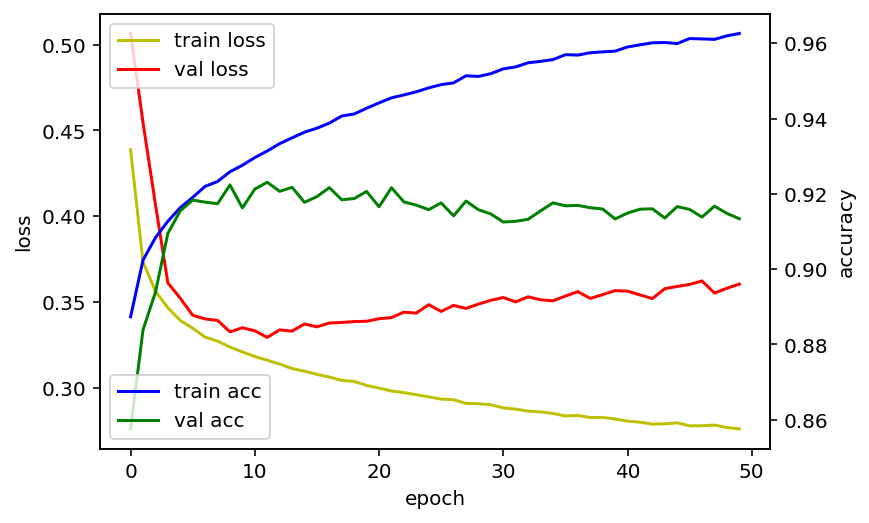

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

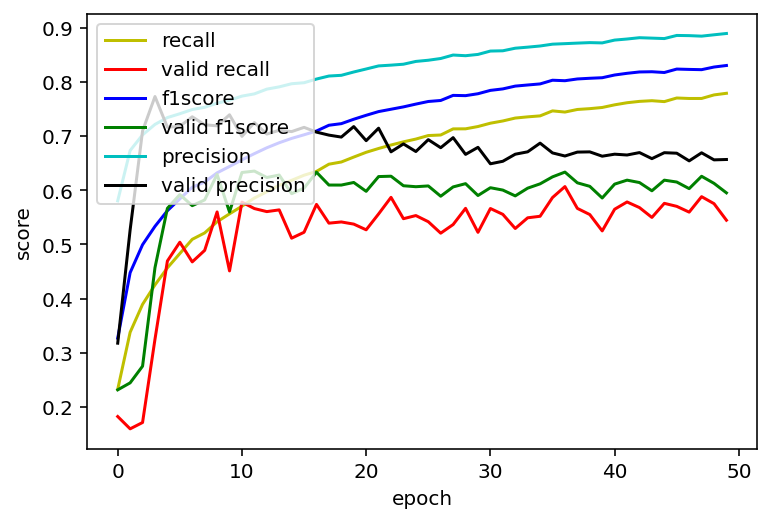

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, recall_ax = plt.subplots()


recall_ax.plot(hist.history['recall'], 'y', label='recall')
recall_ax.plot(hist.history['val_recall'], 'r', label='valid recall')

recall_ax.plot(hist.history['f1score'], 'b', label='f1score')
recall_ax.plot(hist.history['val_f1score'], 'g', label='valid f1score')

recall_ax.plot(hist.history['precision'], 'c', label='precision')
recall_ax.plot(hist.history['val_precision'], 'k', label='valid precision')

recall_ax.set_xlabel('epoch')
recall_ax.set_ylabel('score')

recall_ax.legend(loc='upper left')

plt.show()

In [ ]:
  classifier.load_weights("/content/drive/My Drive/MARG/models/deeperppddbest.h5")#loading for best classifier model
  testresult=classifier.predict(test_matrix)

In [ ]:
print(testresult)

[[0.08278391 0.04773369 0.73016024 ... 0.61669093 0.12768939 0.18231961]
 [0.07425997 0.15304619 0.06068414 ... 0.34839398 0.05407107 0.8883326 ]
 [0.08851555 0.06743321 0.11701334 ... 0.66664803 0.08204085 0.07818818]
 ...
 [0.08243275 0.26070023 0.08585414 ... 0.6491476  0.1452314  0.44475472]
 [0.06327191 0.05660373 0.13097918 ... 0.7735016  0.1183916  0.11652383]
 [0.09089202 0.06886783 0.1481395  ... 0.5410464  0.55461556 0.06051788]]


In [ ]:
def get_tag_results(testresult,test_label2):  
  classnum={}
  testnum={}
  resultmat=[]
  bestmat=[]
  for i in range(len(testresult)):
    eval_result=[0 for i in range(13)]
    best_result=[0 for i in range(13)]
    class_num=np.count_nonzero(test_label2[i]==1)+1
    classidx=(-testresult[i]).argsort()[:class_num]
    for k,j in enumerate(classidx):
      if (k==0):
        best_result[j]=1
      eval_result[j]=1
    resultmat.append(eval_result)
    bestmat.append(best_result)
    test_result2=copy.deepcopy(testresult)
    test_result2[np.where(test_result2>0.30)]=1
    test_result2[np.where(test_result2<=0.30)]=0
  resultmat=np.array(resultmat)
  bestmat=np.array(bestmat)
  testidx=mlb.inverse_transform(resultmat)
  classidx=mlb.inverse_transform(test_label2)
  testidx2=mlb.inverse_transform(test_result2)
  bestidx=mlb.inverse_transform(bestmat)
  for i in range(len(testidx)):  
    for classes in classidx[i]:
      if (classes not in classnum):
        classnum[classes]=1
      else:
        classnum[classes]+=1
    for classes in testidx[i]:
      if (classes not in testnum):
        testnum[classes]=1
      else:
        testnum[classes]+=1
  print(classnum, testnum)
  return bestidx, testidx2, testidx, classidx
best=get_tag_results(testresult,test_label2)[0]
print(best)


{'down_leaping': 119, 'triplet': 883, 'steping_twisting': 234, 'up_steping': 369, 'no skills': 709, 'repeating': 124, 'leaping_twisting': 264, 'up_leaping': 148, 'continuing_rhythm': 27, 'down_steping': 166, 'One_rhythm': 54, 'fast_rhythm': 73} {'down_leaping': 160, 'leaping_twisting': 377, 'triplet': 1257, 'continuing_rhythm': 561, 'steping_twisting': 247, 'up_steping': 522, 'down_steping': 246, 'no skills': 999, 'repeating': 234, 'up_leaping': 234, 'One_rhythm': 88, 'fast_rhythm': 306, 'staccato': 25}
[('down_leaping',), ('up_steping',), ('down_steping',), ('triplet',), ('no skills',), ('repeating',), ('down_leaping',), ('triplet',), ('down_leaping',), ('triplet',), ('triplet',), ('repeating',), ('up_steping',), ('up_leaping',), ('triplet',), ('no skills',), ('down_leaping',), ('triplet',), ('triplet',), ('no skills',), ('steping_twisting',), ('no skills',), ('no skills',), ('no skills',), ('no skills',), ('no skills',), ('no skills',), ('no skills',), ('no skills',), ('no skills',),

[('up_steping',)]


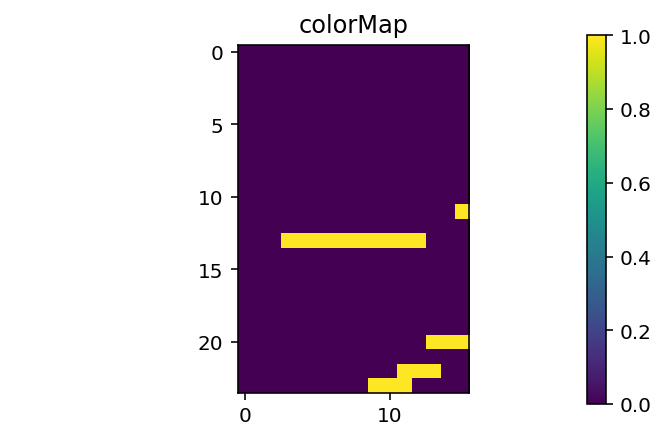

In [ ]:
prediction=classifier.predict(test_matrix[460].reshape(1,24,Minimum_time,1))
categorical=np.zeros_like(prediction)
num=np.argmax(prediction)
categorical[0][num]=1
label=mlb.inverse_transform(categorical)
print(label)
H = test_matrix[460].reshape(24,Minimum_time)
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

Implementation of GAN 

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
def get_best_results(testresult,test_label2):  #for optimizing get_tag_results function
  classnum={}
  testnum={}
  resultmat=[]
  bestmat=[]
  for i in range(len(testresult)):
    best_result=[0 for i in range(13)]
    class_num=np.count_nonzero(test_label2[i]==1)+1
    classidx=(-testresult[i]).argsort()[:class_num]
    for k,j in enumerate(classidx):
      if (k==0):
        best_result[j]=1
    bestmat.append(best_result)
  bestmat=np.array(bestmat)
  bestidx=mlb.inverse_transform(bestmat)
  return bestidx

In [ ]:
trainX=train_matrix.reshape((int(len(all_matrix)*0.85),24,Minimum_time))
for i in tqdm(range(int(len(train_matrix)//1000)),position=0):
  if(i==0):
    test_result=classifier.predict(train_matrix[1000*i:1000+1000*i])
  else:
    sub_testresult=classifier.predict(train_matrix[1000*i:1000+1000*i])
    test_result=np.concatenate((test_result,sub_testresult))
sub_testresult=classifier.predict(train_matrix[1000*(i+1):])
test_result=np.concatenate((test_result,sub_testresult))
trainy=np.array(get_best_results(test_result,train_label2)).reshape((int(len(all_matrix)*0.85),))
print('Train', trainX.shape, trainy.shape)

100%|██████████| 35/35 [00:01<00:00, 18.69it/s]


Train (35458, 24, 16) (35458,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(trainy)
trainy = encoder.transform(trainy)
print(trainy)
trainy=np.array(trainy)

[ 9 10  9 ...  9  9  9]


In [ ]:
import numpy as np
import scipy as sp
import scipy.ndimage
def blur_image(matrix):
  sigma_y = 0.5
  sigma_x = 0.5
  inputmat=matrix
  # Apply gaussian filter
  sigma = [sigma_y, sigma_x]
  y = sp.ndimage.filters.gaussian_filter(inputmat, sigma, mode='constant')
  return y


In [ ]:
blur_trainX=copy.deepcopy(trainX)
for i,matrix in enumerate(trainX):
  blur_trainX[i]=blur_image(matrix)
trainX=blur_trainX

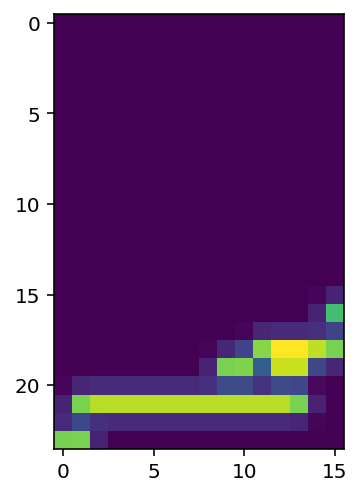

In [ ]:
plt.imshow(trainX[236])

In [ ]:
#These scripts refer to https://github.com/gaborvecsei/CDCGAN-Keras/tree/master/cdcgan.

import matplotlib

matplotlib.use('Agg')
from keras import models, layers

ACTIVATION = layers.Activation("tanh")


def generator_model(minimum_time):
    # Prepare noise input
    input_z = layers.Input((13,))
    dense_z_1 = layers.Dense(1024)(input_z)
    act_z_1 = ACTIVATION(dense_z_1)
    dense_z_2 = layers.Dense(128 * 6 * int(minimum_time/4))(act_z_1)
    bn_z_1 = layers.BatchNormalization()(dense_z_2)
    reshape_z = layers.Reshape((6, int(minimum_time/4), 128), input_shape=(128 * 6 * int(minimum_time/4),))(bn_z_1)

    # Prepare Conditional (label) input
    input_c = layers.Input((13,))
    dense_c_1 = layers.Dense(1024)(input_c)
    act_c_1 = ACTIVATION(dense_c_1)
    dense_c_2 = layers.Dense(128 * 6 * int(minimum_time/4))(act_c_1)
    bn_c_1 = layers.BatchNormalization()(dense_c_2)
    reshape_c = layers.Reshape((6, int(minimum_time/4), 128), input_shape=(128 * 6 * int(minimum_time/4),))(bn_c_1)

    # Combine input source
    concat_z_c = layers.Concatenate()([reshape_z, reshape_c])

    # Image generation with the concatenated inputs
    up_1 = layers.UpSampling2D(size=(2, 2))(concat_z_c)
    conv_1 = layers.Conv2D(64, (5, 5), padding='same')(up_1)
    act_1 = ACTIVATION(conv_1)
    up_2 = layers.UpSampling2D(size=(2, 2))(act_1)
    conv_2 = layers.Conv2D(1, (5, 5), padding='same')(up_2)
    act_2 = layers.Activation("tanh")(conv_2)
    model = models.Model(inputs=[input_z, input_c], outputs=act_2)
    return model


def discriminator_model(minimum_time):
    input_gen_image = layers.Input((24, minimum_time, 1))
    conv_1_image = layers.Conv2D(64, (5, 5), padding='same')(input_gen_image)
    act_1_image = ACTIVATION(conv_1_image)
    pool_1_image = layers.MaxPooling2D(pool_size=(2, 2))(act_1_image)
    conv_2_image = layers.Conv2D(128, (5, 5))(pool_1_image)
    act_2_image = ACTIVATION(conv_2_image)
    pool_2_image = layers.MaxPooling2D(pool_size=(2, 2))(act_2_image)

    input_c = layers.Input((13,))
    dense_1_c = layers.Dense(1024)(input_c)
    act_1_c = ACTIVATION(dense_1_c)
    dense_2_c = layers.Dense(4 * int(minimum_time/4-2) * 128)(act_1_c)
    bn_c = layers.BatchNormalization()(dense_2_c)
    reshaped_c = layers.Reshape((4, int(minimum_time/4-2), 128))(bn_c)

    concat = layers.Concatenate()([pool_2_image, reshaped_c])

    flat = layers.Flatten()(concat)
    dense_1 = layers.Dense(1024)(flat)
    act_1 = ACTIVATION(dense_1)
    dense_2 = layers.Dense(1)(act_1)
    act_2 = layers.Activation('sigmoid')(dense_2)
    model = models.Model(inputs=[input_gen_image, input_c], outputs=act_2)
    return model


def generator_containing_discriminator(g, d):
    input_z = layers.Input((13,))
    input_c = layers.Input((13,))
    gen_image = g([input_z, input_c])
    d.trainable = False
    is_real = d([gen_image, input_c])
    model = models.Model(inputs=[input_z, input_c], outputs=is_real)
    return model

In [ ]:
import math
import os
import subprocess

import cv2
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np


def combine_images(generated_images):
    num_images = generated_images.shape[0]
    new_width = int(math.sqrt(num_images))
    new_height = int(math.ceil(float(num_images) / new_width))
    grid_shape = generated_images.shape[1:3]
    grid_image = np.zeros((new_height * grid_shape[0], new_width * grid_shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / new_width)
        j = index % new_width
        grid_image[i * grid_shape[0]:(i + 1) * grid_shape[0], j * grid_shape[1]:(j + 1) * grid_shape[1]] = \
            img[:, :, 0]
    return grid_image


def generate_noise(shape: tuple):
    noise = np.random.uniform(0, 1, size=shape)
    return noise


def generate_condition_embedding(label: int, nb_of_label_embeddings: int):
    label_embeddings = np.zeros((nb_of_label_embeddings, 13))
    label_embeddings[:, label] = 1
    return label_embeddings


def generate_images(generator, nb_images: int, label: int):
    noise = generate_noise((nb_images, 13))
    label_batch = generate_condition_embedding(label, nb_images)
    generated_images = generator.predict([noise, label_batch], verbose=0)
    return generated_images


def generate_mnist_image_grid(generator, title: str = "Generated images"):
    generated_images = []

    for i in range(10):
        noise = generate_noise((10, 13))
        label_input = generate_condition_embedding(i, 10)
        gen_images = generator.predict([noise, label_input], verbose=0)
        generated_images.extend(gen_images)

    generated_images = np.array(generated_images)
    image_grid = combine_images(generated_images)
    image_grid = inverse_transform_images(image_grid)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(image_grid, cmap="gray")
    ax.set_title(title)
    fig.canvas.draw()

    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close()

    return image


def save_generated_image(image, epoch, iteration, folder_path):
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    file_path = "{0}/{1}_{2}.png".format(folder_path, epoch, iteration)
    cv2.imwrite(file_path, image.astype(np.uint8))


def transform_images(images: np.ndarray):
    """
    [0,1]Transform images to [-1, 1]
    """
    max_value=images.max()

    images = (images.astype(np.float32) - (max_value/2)) / (max_value/2)
    return images


def inverse_transform_images(images: np.ndarray):
    """
    From the [-1, 1] range transform the images back to [0, 255]
    """

    images = images * 127.5 + 127.5
    images = images.astype(np.uint8)
    return images


def convert_video_to_gif(input_video_path, output_gif_path, fps=24):
    palette_image_path = "palette.png"
    command_palette = 'ffmpeg -y -t 0 -i {0} -vf fps={1},scale=320:-1:flags=lanczos,palettegen {2}'.format(input_video_path,
                                                                                                           fps,
                                                                                                           palette_image_path)
    command_convert = 'ffmpeg -y -t 0 -i {0} -i {1} -filter_complex "fps={2},scale=320:-1:flags=lanczos[x];[x][1:v]paletteuse" {3}'.format(input_video_path,palette_image_path, fps, output_gif_path)
    
    try:
        subprocess.check_call(command_palette)
        subprocess.check_call(command_convert)
    except subprocess.CalledProcessError as exc:
        print(exc.output)
        raise
    finally:
        os.remove(palette_image_path)

In [ ]:
pip install git+https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git

  Cloning https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git to /tmp/pip-req-build-nvyl0dw3
  Running command git clone -q https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git /tmp/pip-req-build-nvyl0dw3
  Created wheel for swiss-army-tensorboard: filename=swiss_army_tensorboard-0.0.1-cp37-none-any.whl size=5377 sha256=8bc33834a1284a38c50719a9324fa9e1f410499f29c5f42ee3b317e74436f2a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-170i50yw/wheels/ea/f7/db/67f8661f9c334ad8eda2d0dfbc21bcaea99f739c97f6008d41
Successfully built swiss-army-tensorboard


In [ ]:
import matplotlib

matplotlib.use('Agg')
import numpy as np
from keras import backend as K
from keras import utils as keras_utils
from keras import optimizers
from keras import datasets
from swiss_army_tensorboard import tfboard_loggers
from tqdm import tqdm

BATCH_SIZE = 128
EPOCHS = 50

# Load & Prepare data

X_train=trainX
y_train=trainy
X_train = transform_images(X_train)
X_train = X_train[:, :, :, None]

y_train = keras_utils.to_categorical(y_train, 13)

# Create the models

G = generator_model(Minimum_time)
D = discriminator_model(Minimum_time)

GD = generator_containing_discriminator(G, D)

optimizer = optimizers.Adam(0.0002, 0.5)

G.compile(loss='binary_crossentropy', optimizer=optimizer)
GD.compile(loss='binary_crossentropy', optimizer=optimizer)
D.trainable = True
D.compile(loss='binary_crossentropy', optimizer=optimizer)


In [ ]:
"""
G.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")
D.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/discriminator.h5")
"""

'\nG.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")\nD.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/discriminator.h5")\n'

In [ ]:
from tensorflow import keras
# Setup Tensorboard loggers

tfboard_loggers.TFBoardModelGraphLogger.log_graph("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs", K.get_session())
loss_logger = tfboard_loggers.TFBoardScalarLogger("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/loss")
image_logger = tfboard_loggers.TFBoardImageLogger("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/generated_images")

# Model Training

iteration = 0
dist_val=0.8
nb_of_iterations_per_epoch = int(X_train.shape[0] / BATCH_SIZE)
print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))

for epoch in range(EPOCHS):
    pbar = tqdm(desc="Epoch: {0}".format(epoch), total=X_train.shape[0],position=0)

    g_losses_for_epoch = []
    d_losses_for_epoch = []

    for i in range(nb_of_iterations_per_epoch):
        noise = generate_noise((BATCH_SIZE, 13))

        image_batch = X_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        label_batch = y_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        generated_images = G.predict([noise, label_batch], verbose=0)
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        label_batches_for_discriminator = np.concatenate((label_batch, label_batch))
        
        if(np.random.random()<dist_val):
            D_loss = D.train_on_batch([X, label_batches_for_discriminator], y)
            d_losses_for_epoch.append(D_loss)
            loss_logger.log_scalar("discriminator_loss", D_loss, iteration)

        noise = generate_noise((BATCH_SIZE, 13))
        D.trainable = False
        G_loss = GD.train_on_batch([noise, label_batch], [1] * BATCH_SIZE)
        D.trainable = True
        g_losses_for_epoch.append(G_loss)
        loss_logger.log_scalar("generator_loss", G_loss, iteration)

        pbar.update(BATCH_SIZE)

        iteration += 1
        
    # Save a generated image for every epoch
    image_grid = generate_mnist_image_grid(G, title="Epoch {0}".format(epoch))
    save_generated_image(image_grid, epoch, 0, "/content/drive/My Drive/MARG/PPDDlist/GAN_result/generated_mnist_images_per_epoch")
    image_logger.log_images("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generated_mnist_images_per_epoch", [image_grid], epoch)

    pbar.close()
    print("D loss: {0}, G loss: {1}".format(np.mean(d_losses_for_epoch), np.mean(g_losses_for_epoch)))
    if(np.mean(g_losses_for_epoch)>1):
      dist_val=0.8
    else:
      dist_val=0.4


    G.save_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")
    D.save_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/discriminator.h5")

/usr/local/lib/python3.7/dist-packages/swiss_army_tensorboard/tfboard_loggers/tfboard_loggers.py:19: UserWarning: Folder /content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/loss is already created, maybe it contains other log files
  warnings.warn("Folder {0} is already created, maybe it contains other log files".format(log_dir))
/usr/local/lib/python3.7/dist-packages/swiss_army_tensorboard/tfboard_loggers/tfboard_loggers.py:19: UserWarning: Folder /content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/generated_images is already created, maybe it contains other log files
  warnings.warn("Folder {0} is already created, maybe it contains other log files".format(log_dir))
Epoch: 0:   0%|          | 0/35458 [00:00<?, ?it/s]

Number of iterations per epoch: 277




Epoch: 0: 100%|█████████▉| 35456/35458 [00:11<00:00, 3192.08it/s]


D loss: 0.31911924481391907, G loss: 3.612621545791626


Epoch: 1: 100%|█████████▉| 35456/35458 [00:07<00:00, 4626.13it/s]


D loss: 0.6458978056907654, G loss: 1.1392030715942383


Epoch: 2: 100%|█████████▉| 35456/35458 [00:07<00:00, 4691.41it/s]


D loss: 0.6839741468429565, G loss: 0.7908486127853394


Epoch: 4:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6841965913772583, G loss: 0.7376241683959961


Epoch: 5:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6936008930206299, G loss: 0.7608880400657654


Epoch: 6:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6768841743469238, G loss: 0.7774552702903748


Epoch: 7:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6770216822624207, G loss: 0.7835777997970581


Epoch: 8:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6658591032028198, G loss: 0.8100565075874329


Epoch: 9:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6810272336006165, G loss: 0.7819302678108215


Epoch: 10:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6597306132316589, G loss: 0.8090488314628601


Epoch: 11:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6673479080200195, G loss: 0.8243420124053955


Epoch: 12:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6464501619338989, G loss: 0.8554122447967529


Epoch: 13:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6647980809211731, G loss: 0.8593266606330872


Epoch: 14:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6427276134490967, G loss: 0.8991257548332214


Epoch: 15:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6536888480186462, G loss: 0.8898229598999023


Epoch: 16:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6206710338592529, G loss: 0.8823016285896301


Epoch: 17:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6237940192222595, G loss: 0.9435880780220032


Epoch: 18:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.6204138398170471, G loss: 1.0363609790802002


Epoch: 19:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.5652601718902588, G loss: 1.0972048044204712


Epoch: 19: 100%|█████████▉| 35456/35458 [00:07<00:00, 4831.05it/s]


D loss: 0.5096231698989868, G loss: 1.2948455810546875


Epoch: 21:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.4606166183948517, G loss: 1.436723232269287


Epoch: 21: 100%|█████████▉| 35456/35458 [00:07<00:00, 4829.64it/s]


D loss: 0.4262654185295105, G loss: 1.632900595664978


Epoch: 22: 100%|█████████▉| 35456/35458 [00:07<00:00, 4616.72it/s]


D loss: 0.3891960382461548, G loss: 1.8082844018936157


Epoch: 23: 100%|█████████▉| 35456/35458 [00:07<00:00, 4809.53it/s]


D loss: 0.3885978162288666, G loss: 1.8811848163604736


Epoch: 25:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.3729621171951294, G loss: 1.9407782554626465


Epoch: 25: 100%|█████████▉| 35456/35458 [00:07<00:00, 4746.73it/s]


D loss: 0.34590837359428406, G loss: 2.071105480194092


Epoch: 26: 100%|█████████▉| 35456/35458 [00:07<00:00, 4735.07it/s]


D loss: 0.3392435908317566, G loss: 2.031165838241577


Epoch: 27: 100%|█████████▉| 35456/35458 [00:07<00:00, 4892.87it/s]


D loss: 0.31037822365760803, G loss: 2.1700029373168945


Epoch: 28: 100%|█████████▉| 35456/35458 [00:07<00:00, 4789.91it/s]


D loss: 0.28484776616096497, G loss: 2.1715123653411865


Epoch: 29: 100%|█████████▉| 35456/35458 [00:07<00:00, 4737.40it/s]


D loss: 0.2585412561893463, G loss: 2.217653512954712


Epoch: 30: 100%|█████████▉| 35456/35458 [00:07<00:00, 4779.58it/s]


D loss: 0.25428998470306396, G loss: 2.2875583171844482


Epoch: 31: 100%|█████████▉| 35456/35458 [00:07<00:00, 4696.03it/s]


D loss: 0.28252723813056946, G loss: 2.365152597427368


Epoch: 32: 100%|█████████▉| 35456/35458 [00:07<00:00, 4822.44it/s]


D loss: 0.2139064371585846, G loss: 1.5459462404251099


Epoch: 34:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.2315712869167328, G loss: 1.8618000745773315


Epoch: 35:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.23996832966804504, G loss: 2.1149144172668457


Epoch: 36:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.21178463101387024, G loss: 1.9767674207687378


Epoch: 37:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.23985153436660767, G loss: 2.5948948860168457


Epoch: 38:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.2159355729818344, G loss: 2.0940680503845215


Epoch: 39:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.23120923340320587, G loss: 2.72124981880188


Epoch: 40:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.199433371424675, G loss: 2.4234371185302734


Epoch: 41:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.1355333775281906, G loss: 1.6955996751785278


Epoch: 42:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.20903132855892181, G loss: 2.453361988067627


Epoch: 42: 100%|█████████▉| 35456/35458 [00:07<00:00, 4729.45it/s]


D loss: 0.2171032875776291, G loss: 2.4713244438171387


Epoch: 43: 100%|█████████▉| 35456/35458 [00:07<00:00, 4691.80it/s]


D loss: 0.2096603810787201, G loss: 2.9362242221832275


Epoch: 44: 100%|█████████▉| 35456/35458 [00:07<00:00, 4775.21it/s]


D loss: 0.1874261051416397, G loss: 2.2561118602752686


Epoch: 45: 100%|█████████▉| 35456/35458 [00:07<00:00, 4678.87it/s]


D loss: 0.218876451253891, G loss: 3.0827972888946533


Epoch: 46: 100%|█████████▉| 35456/35458 [00:07<00:00, 4812.63it/s]


D loss: 0.21166658401489258, G loss: 3.0358996391296387


Epoch: 48:   0%|          | 0/35458 [00:00<?, ?it/s]

D loss: 0.20194900035858154, G loss: 2.955862045288086


Epoch: 48: 100%|█████████▉| 35456/35458 [00:07<00:00, 4789.17it/s]


D loss: 0.19424961507320404, G loss: 2.9379727840423584


Epoch: 49: 100%|█████████▉| 35456/35458 [00:07<00:00, 4773.04it/s]


D loss: 0.1839952915906906, G loss: 2.8272807598114014


['One_rhythm' 'continuing_rhythm' 'down_leaping' 'down_steping'
 'fast_rhythm' 'leaping_twisting' 'no skills' 'repeating'
 'steping_twisting' 'triplet' 'up_leaping' 'up_steping']


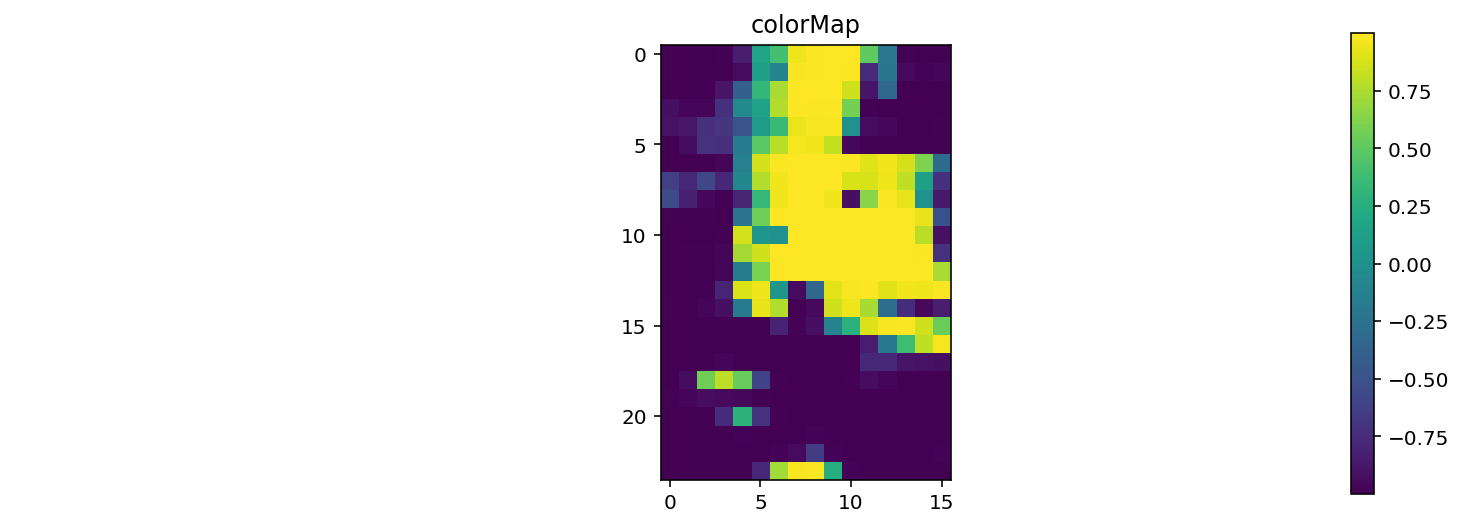

In [ ]:
print(encoder.classes_)
image=generate_images(G,1,1)
H = image[0].reshape((24,Minimum_time))

fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

Implementation of RNN








In [ ]:
RNNx_train=[]
RNNy_train=[]
RNNx_test=[]
RNNy_test=[]
RNN_kfoldx=[]
RNN_kfoldy=[]
for i in range(len(bar_matrix_list3)):
  nowseq=[]
  nowmat=np.array(bar_matrix_list3[i])
  nowbars=classifier.predict(nowmat.reshape(len(nowmat),24,Minimum_time,1) )
  for j,bars in enumerate(nowbars):
    if(j==len(nowbars)-1):
      if(i>=400):
        RNNy_test.append(np.argmax(bars))
      else:
        RNNy_train.append(np.argmax(bars))
      RNN_kfoldy.append(np.argmax(bars))
    else:
      nowseq.append(np.argmax(bars)+1)
  if(i>=400):
    RNNx_test.append(nowseq)
  else:
    RNNx_train.append(nowseq)
  RNN_kfoldx.append(nowseq)

In [ ]:
from keras.utils import to_categorical
print(len(RNNx_train),len(RNNx_train[0]))
print(RNNy_train)
print(to_categorical(RNNy_train))
print(mlb.inverse_transform(to_categorical(RNNy_train)))

400 59
[6, 12, 10, 0, 10, 6, 11, 6, 6, 10, 3, 10, 10, 10, 10, 4, 4, 4, 12, 10, 10, 5, 10, 6, 6, 10, 10, 3, 12, 10, 10, 6, 10, 12, 6, 2, 6, 5, 10, 12, 10, 10, 10, 6, 10, 6, 10, 10, 12, 12, 10, 10, 5, 6, 4, 6, 12, 10, 5, 10, 10, 10, 2, 3, 6, 2, 4, 1, 10, 10, 12, 10, 12, 5, 12, 5, 10, 5, 1, 12, 10, 6, 10, 10, 6, 6, 6, 10, 10, 10, 5, 10, 12, 6, 10, 5, 10, 10, 10, 12, 10, 6, 12, 10, 10, 10, 2, 10, 12, 10, 10, 6, 6, 10, 6, 10, 10, 12, 10, 6, 6, 10, 6, 3, 4, 11, 12, 10, 12, 10, 10, 3, 10, 12, 6, 4, 2, 11, 6, 12, 10, 12, 10, 10, 6, 12, 11, 10, 10, 10, 10, 11, 11, 4, 10, 10, 10, 6, 10, 12, 10, 7, 6, 10, 10, 10, 10, 12, 6, 6, 12, 4, 10, 10, 10, 10, 6, 12, 10, 2, 11, 10, 12, 9, 2, 10, 12, 2, 6, 10, 10, 3, 6, 10, 11, 5, 10, 3, 12, 9, 6, 6, 3, 10, 6, 12, 10, 6, 6, 3, 11, 1, 12, 6, 6, 6, 6, 10, 10, 6, 10, 6, 12, 5, 5, 10, 6, 12, 10, 6, 10, 10, 6, 10, 6, 12, 1, 12, 6, 1, 12, 4, 6, 5, 12, 10, 9, 10, 6, 10, 6, 6, 6, 6, 7, 10, 6, 10, 10, 6, 10, 10, 3, 6, 6, 10, 10, 10, 6, 6, 6, 10, 6, 4, 6, 10, 10, 10, 

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
RNNy_test=to_categorical(np.array(RNNy_test))
RNNy_train=to_categorical(np.array(RNNy_train))
RNN_kfoldy=to_categorical(np.array(RNN_kfoldy))
# fix random seed for reproducibility
numpy.random.seed(7)
top_words=13
# truncate and pad input sequences

RNNx_train = sequence.pad_sequences(RNNx_train, maxlen=10)
RNNx_test = sequence.pad_sequences(RNNx_test, maxlen=10)
RNN_kfoldx = sequence.pad_sequences(RNN_kfoldx, maxlen=10)


In [ ]:
print(RNN_kfoldx.shape, RNN_kfoldy.shape)

(662, 10) (662, 13)


In [ ]:
unique, counts = numpy.unique(RNN_kfoldx, return_counts=True)
RNN_weight=dict(zip(unique, 5000/counts))

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_path = '/content/drive/My Drive/MARG/models/' + 'RNN.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
callbacks = [cb_checkpoint]

In [ ]:
from keras import regularizers
# create the model
embedding_vecor_length = 32
timesteps = 8

RNNmodel = Sequential()
RNNmodel.add(Embedding(top_words, embedding_vecor_length, input_length=10))
RNNmodel.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, 100)))  # returns a sequence of vectors of dimension 32
RNNmodel.add(LSTM(100))  # return a single vector of dimension 32
RNNmodel.add(Dropout(0.2))
RNNmodel.add(Dense(13, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

RNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
for i in range(3):
  for train,valid in kfold.split(RNN_kfoldx,RNN_kfoldy):
    RNNmodel.fit(RNN_kfoldx[train],RNN_kfoldy[train], validation_data=(RNN_kfoldx[valid],RNN_kfoldy[valid])
    ,epochs=15, batch_size=64,callbacks=callbacks, class_weight='balanced')

Train on 529 samples, validate on 133 samples
Epoch 1/15
529/529 [==============================] - 1s 2ms/step - loss: 2.7583 - accuracy: 0.3724 - val_loss: 2.6852 - val_accuracy: 0.4361

Epoch 00001: val_accuracy improved from -inf to 0.43609, saving model to /content/drive/My Drive/MARG/models/RNN.h5
Epoch 2/15
529/529 [==============================] - 0s 326us/step - loss: 2.5651 - accuracy: 0.4253 - val_loss: 2.3254 - val_accuracy: 0.4361

Epoch 00002: val_accuracy did not improve from 0.43609
Epoch 3/15
529/529 [==============================] - 0s 309us/step - loss: 2.2303 - accuracy: 0.4253 - val_loss: 2.0045 - val_accuracy: 0.4361

Epoch 00003: val_accuracy did not improve from 0.43609
Epoch 4/15
529/529 [==============================] - 0s 306us/step - loss: 2.0500 - accuracy: 0.4253 - val_loss: 1.9345 - val_accuracy: 0.4361

Epoch 00004: val_accuracy did not improve from 0.43609
Epoch 5/15
529/529 [==============================] - 0s 317us/step - loss: 2.0155 - accuracy: 

In [ ]:
scores = RNNmodel.evaluate(RNNx_test, RNNy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 73.66%


In [ ]:
print(RNNmodel.predict(RNNx_test))

[[0.00248238 0.00241658 0.0088703  ... 0.4936056  0.00499833 0.01331398]
 [0.0092403  0.02162519 0.00273284 ... 0.02403879 0.00152972 0.02752379]
 [0.00075898 0.00132415 0.00501251 ... 0.29274678 0.00561759 0.11965176]
 ...
 [0.00079453 0.00139302 0.00561106 ... 0.06032386 0.00498995 0.27851677]
 [0.00127402 0.00597054 0.0025925  ... 0.00739488 0.00784126 0.01670647]
 [0.00462162 0.00506273 0.01913443 ... 0.6651224  0.02677426 0.01440033]]


In [ ]:
#Model Loading Only. I don't know why RNN model loading has Nonetype issue...
#10000MIDI's Model training time is about 2~3hour. especially long for
G = generator_model(Minimum_time)
G.compile(loss='binary_crossentropy', optimizer=optimizer)
G.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")

updown_classifier=make_classifier(Minimum_time)
updown_classifier.compile(loss=keras.losses.CategoricalCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='categorical_crossentropy'
  ), optimizer='adam', metrics=['accuracy'])
updown_classifier.load_weights("/content/drive/My Drive/MARG/models/updown.h5")

classifier=make_model(Minimum_time)
classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='binary_crossentropy'
  ), optimizer='adam', metrics=['accuracy',recall,precision,f1score])
classifier.load_weights("/content/drive/My Drive/MARG/models/deeperppddbest.h5")

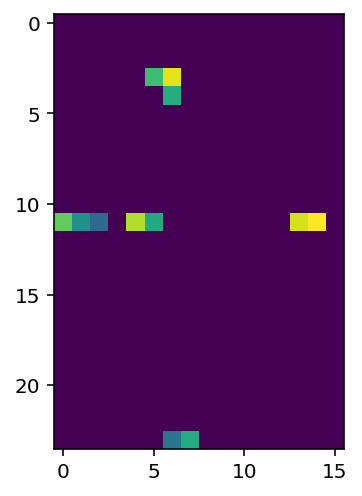

In [ ]:
import cv2
H=generate_images(G,5,3)[0]

def matrix_cleaner(matrix,minimum_time):
  #matrix should be size of 24*24
  #make matrix's value of [0,1]  
  matrix=np.matrix(matrix)
  maximum_value=matrix.max()
  minimum_value=matrix.min()
  matrix=(matrix-minimum_value)/(maximum_value-minimum_value)
  flat=matrix.flatten()
  flat.sort()
  flat=flat.reshape((24*minimum_time,1))
  hundred_val=flat[-100]
  matrix_for_duration=np.where(matrix<0.05,0,matrix)
  matrix=np.where(matrix<hundred_val,0,matrix)
  matrix=np.where(matrix<1/3,0,matrix)
  
  return matrix,matrix_for_duration
plt.imshow(matrix_cleaner(H,Minimum_time)[0])

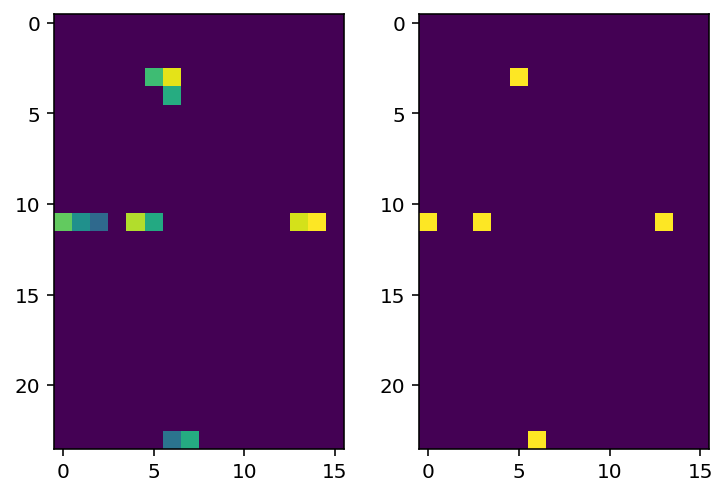

In [ ]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp

#getting a list of images

paws = [matrix_cleaner(H,Minimum_time)[0]]


def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background
    detected_peaks=np.where(detected_peaks==True,1,0)
    
    for i in range(len(detected_peaks[0])):
      for j in range(len(detected_peaks)):
        if(detected_peaks[j][i]==1):
          for k in range(i):
            if (image[j][i-k-1] is not 0 and image[j][i-k-1] > image[j][i-k]):
              pass
            else:
              detected_peaks[j][i]=0
              detected_peaks[j][i-k-1]=1 #this code can decide note's position well.
              break
    
    #위 코드를 돌리면 앞으로 댕긴다.
    return detected_peaks


#applying the detection and plotting results
for i, paw in enumerate(paws):
    detected_peaks = detect_peaks(paw)
    pp.subplot(1,2,(2*i+1))
    pp.imshow(paw)
    pp.subplot(1,2,(2*i+2) )
    pp.imshow(detected_peaks)

pp.show()

[[11  0]
 [11  3]
 [ 3  5]
 [23  6]
 [11 13]] [ 3 10  3  2  3] [0.75886458 0.4        0.68779773 0.4        0.93551183]


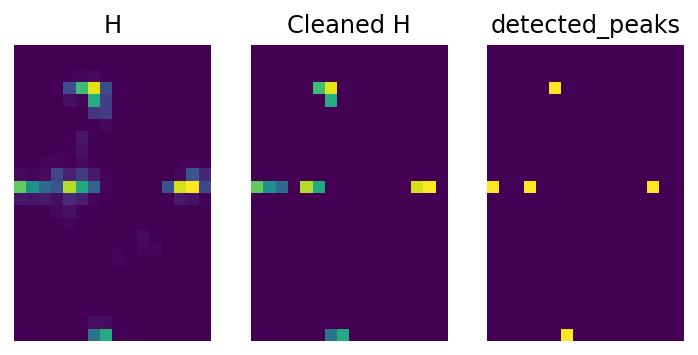

In [ ]:
def left_shifting(matrix,detected_peak,minimum_time):
  dots=[]
  times=[]
  for i in range(len(detected_peak[0])):
    for j in range(len(detected_peak)):
      if(detected_peak[j][i]==1):
        if(i%2!=0 and i%3!=0 and i==15 and i==9 and i==7):#this code can shift Offbeats like 5/24, 7/24 to 4/24, 6/24, 
          detected_peak[j][i]=0
          detected_peak[j][i]=1 # i-1 to i makes left shifting off.


  for i in range(len(detected_peak[0])):
    for j in range(len(detected_peak)):
      pos=[]
      a=0
      if(detected_peak[j][i]==1):  
        pos=[j,i]
      if(len(pos)!=0):
        dots.append(pos)
        times.append(i)
  dots_with_length=[]
  starting_points=[]
  durations=[]
  velocities=[]
  for i,position in enumerate(dots):
    velocity=matrix[1][position[0]][position[1]]
    if(position[1]!=0):

      if(velocity<matrix[1][position[0]][position[1]-1]):
        velocity=matrix[1][position[0]][position[1]-1] #for handling shifted notes
        #Note that matrix[1][position[0]][position[1]>matrix[1][position[0]][position[1]-1] for all none-shifted notes since
        #peak notes selected by local maximum neighboorhood.

      if velocity < 0.4:
        velocity=0.4

        #구현이 바뀌어서 이렇게 해야함
    velocities.append(velocity)
    length_val=0
    while True:
      if(length_val==0):
        starting_points.append([position[0],position[1]])
      else:
        if(position[1]+length_val>minimum_time-1):
          break
        if(detected_peak[position[0]][position[1]+length_val]!=0):
          break
      if(position[1]+length_val>minimum_time-1):
        break
      elif(matrix[1][position[0]][position[1]+length_val]!=0):
        dots_with_length.append([position[0],position[1]+length_val])
        times.append(position[1]+length_val)
      else:
        break
      length_val+=1

    while True:
      if(position[1]+length_val not in times and position[1]+length_val<minimum_time):
        dots_with_length.append([position[0],position[1]+length_val])
        times.append(position[1]+length_val)
        length_val+=1   
      else:
        break
    durations.append(length_val)
  result=np.zeros_like(matrix[0])
  for position in dots_with_length:
    result[position[0]][position[1]]=1
  return result,np.array(starting_points),np.array(durations),np.array(velocities)

paws = [matrix_cleaner(H,Minimum_time)[0]]
detected_peaks = detect_peaks(paws[0])
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(H.reshape(24,Minimum_time))
ax1.set_title('H')
ax1.axis("off")
 
ax3 = fig.add_subplot(1, 3, 2)
ax3.imshow(paws[0].reshape(24,Minimum_time))
ax3.set_title('Cleaned H')
ax3.axis("off")

ax2 = fig.add_subplot(1, 3, 3)
ax2.imshow(detect_peaks(matrix_cleaner(H,Minimum_time)[0]))
ax2.set_title('detected_peaks')
ax2.axis("off")
#plt.imshow(left_shifting(matrix_cleaner(H),detect_peaks(matrix_cleaner(H)[0]))[0])
print(
    left_shifting(matrix_cleaner(H,Minimum_time),detected_peaks,Minimum_time)[1],
      left_shifting(matrix_cleaner(H,Minimum_time),detected_peaks,Minimum_time)[2],
      left_shifting(matrix_cleaner(H,Minimum_time),detected_peaks,Minimum_time)[3])

In [ ]:
import random
C_chord=np.array([1,0,1,0,1,1,0,1,0,1,0,1])
I_chord=np.array([1,0,0,0,1,0,0,1,0,0,0,0])
V_chord=np.array([0,0,1,0,0,0,0,1,0,0,0,1])
vi_chord=np.array([1,0,0,0,1,0,0,0,0,1,0,0])
IV_chord=np.array([1,0,0,0,0,1,0,0,0,1,0,0])
iii_chord=np.array([0,0,0,0,1,0,0,1,0,0,0,1])
ii_chord=np.array([0,0,1,0,0,1,0,0,0,1,0,0])
C_chords=np.array([I_chord,V_chord,vi_chord,IV_chord,iii_chord,ii_chord])

chords=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
def chord_matching(shifted_matrix,chord,last_pitch,direction,with_chords=False):
  selected_chords=None
  before_matrix=shifted_matrix[0]
  before_pitch=last_pitch
  if (last_pitch<50):
    direction=1
  if (last_pitch>85):
    direction=0
  if chord not in chords:
    now_chord='C'
  now_chord=chord
  chord_diff=chords.index(now_chord)
  now_chord_list=np.roll(C_chord,chord_diff)#[1,0,1,0,1...]
  now_chords=[]
  for chord in C_chords:
    now_chords.append(np.roll(chord,chord_diff))
  pitch_set=[]
  for pitchs in shifted_matrix[1]:
    pitch_set.append(23-pitchs[0])
  pitch_set=pitch_set-pitch_set[0]#ex)0, 10, -1, 0 ,-4, -2
  if (direction==1):
    possible_set=[]
    for i in range(12):
      possible_set.append(pitch_set+i+last_pitch)
  else:
    possible_set=[]
    for i in range(12):
      possible_set.append(pitch_set-i+last_pitch)
  possible_set_score=[]
  if (with_chords):
    selected_chords=random.choice(now_chords)
    for sets in possible_set:
      score=0
      for pitchs in sets:
        score+=selected_chords[pitchs%12]
      possible_set_score.append(score)
    final_set=possible_set[np.argmax(possible_set_score)]
    return_val=[]
  else:
    for sets in possible_set:
      score=0
      for pitchs in sets:
        score+=now_chord_list[pitchs%12]
      possible_set_score.append(score)
    final_set=possible_set[np.argmax(possible_set_score)]
    return_val=[]
  for i,sets in enumerate(final_set):
    if (before_pitch-sets<-12):
      sets=sets-12
    if (before_pitch-sets>12):
      sets=sets+12               #For prevent pitch change above 1 Octave.

    if(now_chord_list[sets%12]==1): #Use only matches with chord
      final=[]
      if (shifted_matrix[2][i]!=0):
        final.append(sets)#pitch
        final.append(shifted_matrix[1][i][1])
        final.append(shifted_matrix[2][i])
        final.append(shifted_matrix[3][i])
        return_val.append(final)
    else:
      final=[]
      if (shifted_matrix[2][i]!=0):
        final.append(sets-1)#pitch shifting for notes that not matches with chord scale. If you want to use these type of notes, just remove -1 in sets-1.
        final.append(shifted_matrix[1][i][1])
        final.append(shifted_matrix[2][i])
        final.append(shifted_matrix[3][i])
        return_val.append(final)
    before_pitch=sets
  return return_val, sets,selected_chords#final pitch


In [ ]:
shifted=left_shifting(matrix_cleaner(H,Minimum_time),detect_peaks(matrix_cleaner(H,Minimum_time)[0]),Minimum_time)
print(chord_matching(shifted,'C',48,1))

([[52, 0, 3, 0.7588645815849304], [52, 3, 10, 0.4], [60, 5, 3, 0.6877977252006531], [52, 6, 2, 0.4], [52, 13, 3, 0.9355118274688721]], 52, None)


In [ ]:
np.random.seed(7)
def generation_info(start_skill,length,chord,minimum_time,RNNmodel,updown_classifier,with_chords=False):
  skills=[]
  skills.append(start_skill)
  infos=[]
  H=generate_images(G,1,start_skill)
  chord_sequence=[]
  shifted=left_shifting(matrix_cleaner(H,minimum_time),detect_peaks(matrix_cleaner(H,minimum_time)[0]),minimum_time)
  Chord_Match=chord_matching(shifted,chord,48,1,with_chords=True)
  infos.append(Chord_Match[0])
  chord_sequence.append(Chord_Match[2])
  last_pitch=Chord_Match[1]

  feature_seq=[]
  feature_seq.append(start_skill+1)
  feature_seq_pad=sequence.pad_sequences(np.array([feature_seq]),maxlen=10)
  prediction=RNNmodel.predict(feature_seq_pad)
  prediction[0][start_skill]=prediction[0][start_skill]/3
  prediction[0][6]=0#no skills
  if(minimum_time%3!=0):
    prediction[0][10]=0 # triplet skill, if minimum_time%3 is not 0, then generator can't handle any triplet notes.
  updown_prediction=updown_classifier.predict(shifted[0].reshape(1,24,minimum_time,1))
  if(updown_prediction[0][0]>=updown_prediction[0][1]):
    updown_prediction=1
  else:
    updown_prediction=0
  prob=prediction/prediction.sum()
  next_skill=np.random.choice(
      np.arange(13),
      p=prob[0]
  )
  skills.append(next_skill)
  for i in range(length-1):
    #print(i+2,'th bar\'s generated skill is ',next_skill)
    H=generate_images(G,1,skills[int((i+1)%4)])
    shifted=left_shifting(matrix_cleaner(H,minimum_time),detect_peaks(matrix_cleaner(H,minimum_time)[0]),minimum_time)
    Chord_Match=chord_matching(shifted,chord,last_pitch,updown_prediction,with_chords=True)
    infos.append(Chord_Match[0])
    chord_sequence.append(Chord_Match[2])
    feature_seq.append(next_skill+1)
    feature_seq_pad=sequence.pad_sequences(np.array([feature_seq]),maxlen=10)
    prediction=RNNmodel.predict(feature_seq_pad)
    prediction[0][next_skill]=prediction[0][next_skill]/3
    prediction[0]=prediction[0]+prediction.sum()/20 # for more variation.
    prediction[0][6]=0#6 is no skill
    updown_prediction=updown_classifier.predict(shifted[0].reshape(1,24,minimum_time,1))
    if(updown_prediction[0][0]>=updown_prediction[0][1]):
      updown_prediction=1
    else:
      updown_prediction=0
    prob=prediction/prediction.sum()
    next_skill=np.random.choice(
        np.arange(13),
        p=prob[0]
    )
    skills.append(next_skill)
  return infos,chord_sequence

In [ ]:
final_list=generation_info(0,16,'C',Minimum_time,RNNmodel,updown_classifier,with_chords=True)
"""
generation_info(final_skill, length, chord)

final_skill should be 0~12. It matches with
['One_rhythm' 'continuing_rhythm' 'down_leaping' 'down_steping'
 'fast_rhythm' 'leaping_twisting' 'no skills' 'resting' 'staccato'
 'steping_twisting' 'triplet' 'up_leaping' 'up_steping'].
 length is the bar number of song generation.
 chord should be string, 'C', 'C#', 'D' ...
 major and minor chord is not considered now.
 but maybe I can handle with making all class as two type. ex)(major One_rhythm, minor One_rhythm..)
"""

"\ngeneration_info(final_skill, length, chord)\n\nfinal_skill should be 0~12. It matches with\n['One_rhythm' 'continuing_rhythm' 'down_leaping' 'down_steping'\n 'fast_rhythm' 'leaping_twisting' 'no skills' 'resting' 'staccato'\n 'steping_twisting' 'triplet' 'up_leaping' 'up_steping'].\n length is the bar number of song generation.\n chord should be string, 'C', 'C#', 'D' ...\n major and minor chord is not considered now.\n but maybe I can handle with making all class as two type. ex)(major One_rhythm, minor One_rhythm..)\n"

In [ ]:
for i in final_list:
  print(i)

[[[50, 0, 5, 0.3560997545719147], [57, 5, 5, 0.8462648391723633], [50, 6, 2, 0.5751287341117859], [57, 10, 3, 0.4], [62, 13, 3, 0.5974671244621277]], [[64, 0, 3, 0.6753873825073242], [64, 3, 10, 0.4], [72, 5, 3, 0.8727115392684937], [64, 6, 2, 0.44475576281547546], [64, 13, 3, 0.6855879426002502]], [[71, 10, 3, 0.4], [76, 13, 3, 0.4]], [[72, 8, 3, 0.5949243903160095], [67, 11, 2, 0.4], [74, 13, 3, 0.4]], [[72, 0, 5, 0.43123844265937805], [79, 5, 5, 0.818239152431488], [79, 10, 3, 0.4], [84, 13, 3, 0.5072353482246399]], [[65, 2, 9, 0.4], [60, 11, 5, 0.8180197477340698]], [[69, 7, 3, 0.4], [69, 10, 3, 0.4], [74, 13, 3, 0.4]], [[72, 4, 4, 0.4], [59, 10, 3, 0.4], [64, 13, 3, 0.4554213881492615]], [[62, 5, 5, 0.41751256585121155], [50, 10, 3, 0.4], [55, 13, 3, 0.4]], [[64, 0, 3, 0.375409871339798], [64, 3, 4, 0.4], [72, 5, 8, 0.9274106025695801], [64, 6, 2, 0.6427728533744812], [64, 13, 3, 0.543957531452179]], [[62, 2, 8, 0.4], [57, 10, 6, 0.4956229627132416]], [[77, 8, 8, 0.801600098609924

In [ ]:
pip install midiutil

     |████████████████████████████████| 1.0MB 8.1MB/s 
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-cp37-none-any.whl size=54570 sha256=ff0335c311d028a31e8bde5b3e63b07047f1f9f0b893ad9d5b214a62d4231bab
  Stored in directory: /root/.cache/pip/wheels/70/f1/24/97bde012f64820632e1e5e2935df19dfbcf9e058b0734b57cd
Successfully built midiutil


In [ ]:
import midiutil
from midiutil.MidiFile import MIDIFile
with_chords=True
for start_skill in range(13):
  for chord in chords:
    final_list=generation_info(start_skill,8,chord,Minimum_time,RNNmodel,updown_classifier,with_chords=with_chords)
    # create your MIDI object
    mf = MIDIFile(2)     # track number - 1
    track = 0   # the main track

    time = 0    # start at the beginning
    mf.addTrackName(track, time, "Sample Track")
    mf.addTempo(track, time, 120)#1bar per 2second.

    # add some notes
    channel = 0
    used_time=[]
    start_pitch=48
    for i,bars in enumerate(final_list[0]):
      lowest_pitch=999
      track = 0
      for notes in bars:
        pitch = notes[0]+12           # My implementation was 48 as C4, but this library think C4 as 60
        if notes[1]%2==0:
          time = notes[1]/(Minimum_time/4)+i*4             # start on beat 0   0~15 / 4
          duration = notes[2]/(Minimum_time/4)
        else:
          time = (notes[1]-1)/(Minimum_time/4)+i*4
          duration = (notes[2]+1)/(Minimum_time/4)         # 1 beat long
        volume= int(notes[3]*100)
        if (time not in used_time and duration!=0): #Delete not in used_time for polyphonic rhythm.
          if volume<30:
            volume=30
          mf.addNote(track, channel, pitch, time, duration, volume)
          used_time.append(time)
          if pitch<lowest_pitch:
            lowest_pitch=pitch
      if (with_chords is True):
        track = 1
        if (lowest_pitch!=999):
          init_pitch=lowest_pitch
        else:
          init_pitch=start_pitch
        chord_idx=np.where(final_list[1][i]==1)
        pitch=0
        iter=0
        pitch_in_chord=[]
        while (pitch<init_pitch):
          for idx in chord_idx[0]:
            pitch=idx+12*iter
            if (pitch>=init_pitch):
              break
            pitch_in_chord.append(pitch)
          iter+=1

        pitch=pitch_in_chord[len(pitch_in_chord)-1]
        time = i*4
        duration=4.0
        volume=50
        mf.addNote(track,channel,pitch,time,duration,volume)
        pitch=pitch_in_chord[len(pitch_in_chord)-2]
        time = i*4
        duration=4.0
        volume=50
        mf.addNote(track,channel,pitch,time,duration,volume)
        pitch=pitch_in_chord[len(pitch_in_chord)-3]
        time = i*4
        duration=4.0
        volume=50
        mf.addNote(track,channel,pitch,time,duration,volume)
        start_pitch=init_pitch
    with open("/content/drive/My Drive/MARG/PPDDlist/MIDI_result/"+mlb.classes_[start_skill]+chord+".mid", 'wb') as outf:
      mf.writeFile(outf)
      print(mlb.classes_[start_skill]+chord+"  generate done!")
      #print('info is \n',final_list)

One_rhythmC  generate done!
One_rhythmC#  generate done!
One_rhythmD  generate done!
One_rhythmD#  generate done!
One_rhythmE  generate done!
One_rhythmF  generate done!
One_rhythmF#  generate done!
One_rhythmG  generate done!
One_rhythmG#  generate done!
One_rhythmA  generate done!
One_rhythmA#  generate done!
One_rhythmB  generate done!
continuing_rhythmC  generate done!
continuing_rhythmC#  generate done!
continuing_rhythmD  generate done!
continuing_rhythmD#  generate done!
continuing_rhythmE  generate done!
continuing_rhythmF  generate done!
continuing_rhythmF#  generate done!
continuing_rhythmG  generate done!
continuing_rhythmG#  generate done!
continuing_rhythmA  generate done!
continuing_rhythmA#  generate done!
continuing_rhythmB  generate done!
down_leapingC  generate done!
down_leapingC#  generate done!
down_leapingD  generate done!
down_leapingD#  generate done!
down_leapingE  generate done!
down_leapingF  generate done!
down_leapingF#  generate done!
down_leapingG  genera